Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# VISTA-2D Cell Segmentation with Segment Anything Model (SAM) & MONAI

![image](../figures/vista_2d_overview.png)

The notebook demonstrates how to train a cell segmentation model using the [MONAI](https://monai.io/) framework and the [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) on the [Cellpose dataset](https://www.cellpose.org/).
In Summary the following steps are performed:
- Initialization of the CellSamWrapper model with pre-trained SAM weights
- Creation of data lists for training, validation, and testing
- Definition of data transforms for training and validation
- Setup of datasets and dataloaders with MONAI
- Implementation of the training loop, including:
    - Loss function (CellLoss)
    - Accuracy function (CellAcc)
    - Optimizer (SGD)
- Mixed precision training with GradScaler
- Sliding window inference via MONAI
- Visualization of training loss, validation loss, and validation accuracy
- Inference on a single validation image
- Visualization of input image, ground truth, and model prediction

The notebook demonstrates a complete pipeline for training and evaluating a cell segmentation model using the MONAI framework and the Segment Anything Model (SAM) on the Cellpose dataset. Please note we only use a small subset of the cellpose dataset for this tutorial.

For additional information about VISTA-2D please also refer the [MONAI bundle](https://github.com/Project-MONAI/VISTA/tree/main/vista2d) and the [technical blog post](https://developer.nvidia.com/blog/advancing-cell-segmentation-and-morphology-analysis-with-nvidia-ai-foundation-model-vista-2d/).

For dependency-related issues, you can also check this note:
https://github.com/Project-MONAI/model-zoo/tree/dev/models/vista2d#dependencies.
If you're using MONAI's container, you can disregard the 'opencv-python-headless not installed' error, as it is already included within the container.

## Check environment

In [1]:
!nvidia-smi
!pip install -q fastremap
!pip install -q --no-deps cellpose

Wed Mar 12 13:52:10 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.6     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:D6:00.0 Off |                    0 |
| N/A   36C    P0              65W / 400W |      2MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Setup imports

You will need the [scripts](https://github.com/Project-MONAI/VISTA/tree/f16b175daa38a2894555e17053d240ebaa9a6501/vista2d/scripts) folder from the Vista2D repo for the imports below to work
The best way to run this notebook would be within the Monai Container toolkit or the Vista2D NGC container. 

In [2]:
import json
import os
import time
import shutil
import tempfile
import gc
from tqdm import tqdm
import tifffile
import random
import warnings
import matplotlib.pyplot as plt
import monai.transforms as mt
import numpy as np
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.inferers import SlidingWindowInfererAdapt
from monai.metrics import CumulativeAverage
from monai.transforms import (Compose, LoadImage, EnsureChannelFirst, ScaleIntensity,
    LoadImaged, MapTransform, RepeatChannel, RepeatChanneld, EnsureChannelFirstd, ScaleIntensityd,ScaleIntensityRangePercentilesd)
from monai.utils import ImageMetaKey
from monai.networks.nets.cell_sam_wrapper import CellSamWrapper
from torch.cuda.amp import GradScaler, autocast

from scripts.components import CellAcc, CellLoss, LabelsToFlows, LoadTiffd, LogitsToLabels

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08.02
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: 4.40.2
mlflow version: 2.16.0
pynrrd version: 1.0.0
clearml version: 1.16.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

Set the root_dir to the folder/volume that was mounted, containing the data files

In [3]:
# TODO - change this to your (mounted) directory
root_dir = "/datasets/monai_workshop"

if not os.path.exists(os.path.join(root_dir,"data")):
    os.mkdir(os.path.join(root_dir,"data"))

if not os.path.exists(os.path.join(root_dir,"vista2d")):
    os.mkdir(os.path.join(root_dir,"vista2d"))

zipfiles_dir = "/datasets/monai_workshop/data/zipfiles"
if not os.path.exists(zipfiles_dir):
    os.mkdir(zipfiles_dir)

## Download Pre-trained weights

In [5]:
sam_weights_path_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_weights_path = os.path.join(root_dir, "vista2d", "sam_vit_b_01ec64.pth")
download_url(url=sam_weights_path_url, filepath=sam_weights_path)

pretrained_weights_url = "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/model_zoo/model_vista2d_v1.pt"
pretrained_weights_url = os.path.join(root_dir, "vista2d", "model_vista2d_v1.pt")
download_url(url=pretrained_weights_url, filepath=sam_weights_path)

2025-03-12 13:53:01,246 - INFO - Expected md5 is None, skip md5 check for file /datasets/monai_workshop/vista2d/sam_vit_b_01ec64.pth.
2025-03-12 13:53:01,246 - INFO - File exists: /datasets/monai_workshop/vista2d/sam_vit_b_01ec64.pth, skipped downloading.
2025-03-12 13:53:01,247 - INFO - Expected md5 is None, skip md5 check for file /datasets/monai_workshop/vista2d/sam_vit_b_01ec64.pth.
2025-03-12 13:53:01,247 - INFO - File exists: /datasets/monai_workshop/vista2d/sam_vit_b_01ec64.pth, skipped downloading.


## Define the network, load SAM weights

You can also load the pretrained weights - if you don't want to retrain

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CellSamWrapper(checkpoint=sam_weights_path)
print("SAM ViT-B weights loaded succesfully ...")

# Optional - omit if you want to train from scratch.
checkpoint = torch.load("/datasets/monai_workshop/vista2d/model_vista2d_v1.pt")
model.load_state_dict(checkpoint["state_dict"], strict=True)

model.to(device)


SAM ViT-B weights loaded succesfully ...


CellSamWrapper(
  (model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3), s

Create functions to facilitate loading of data from various sources and getting it into a train/val/test format

In [7]:
import requests
import zipfile
from tqdm import tqdm
from skimage import io
from scipy import ndimage
import fastremap
import skimage

Segmentation_Dataset = {}
Segmentation_Dataset['Train']=[]
Segmentation_Dataset['Test']=[]
Segmentation_Dataset['Validation']=[]

def extract(zip_dest_path, extract_to):
    if not os.path.exists(extract_to):
        os.mkdir(extract_to)
        
    print(f"Unzipping dataset to {extract_to}...")
    with zipfile.ZipFile(zip_dest_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print("Unzipping completed.")

def add_item(image, labels, items, dataset, stain="H&E",licence="CC BY 4.0"):
    item = {}
    item['image']=image
    item['label']=labels #fastremap.refit(labels)
    item['fold']=0

    items.append(item)

    return items

def separate_touching_objects(lab):
    from scipy.ndimage import distance_transform_edt
    from skimage.segmentation import watershed
    from skimage.measure import label

    mask = lab > 0
    distance_map = distance_transform_edt(mask) 
    markers = distance_map > 2
    markers = label(markers)
    labels = watershed(-distance_map, markers, mask=mask)
    labels = labels + lab
    
    return labels

    
def show_data(item):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    temp_dataset = Dataset(data=item, transform=LoadImaged(keys=["image", "label"]))
    temp_loader = DataLoader(temp_dataset, batch_size=1, shuffle=False, num_workers=1)
    for idx, batch_data in enumerate(temp_loader):
        break
    
    image = np.uint8(batch_data['image'])
    label = batch_data['label']
    
    # Handle potential multi-channel 
    image = np.squeeze(image)
        
    if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
        image = np.transpose(image, (1, 2, 0))
        #if image.shape[2] == 1:
        #    image = image[:, :, 0]
    if image.ndim == 3 and image.shape[2]>3:
        image = image[:,:,:3]

    axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
    axes[0].set_title("Sample Image")
    axes[0].axis("off")
    
    label = np.squeeze(label)
    if label.ndim == 3 and label.shape[0] in [1, 3, 4]:
        label = np.transpose(label, (1, 2, 0))

    if label.ndim == 3 and label.shape[2]>3:
        label = label[:,:,:3]
        
    axes[1].imshow(label)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

## LIVECell

Download and prepare the LiveCell data and add to a training/test/val list

Note that the numbers have been limited to 500,100 & 20 for the train/val/test sets, but this can be changed using the n parameter for load_lc_items

NOTE! Installing ujson may make loading annotations faster.
Loading annotations into memory...


Done (t=13.34s)
Creating index...
index created!


100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


Loading annotations into memory...


Done (t=1.42s)
Creating index...
index created!


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


Loading annotations into memory...


Done (t=6.98s)
Creating index...
index created!


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


120 items added


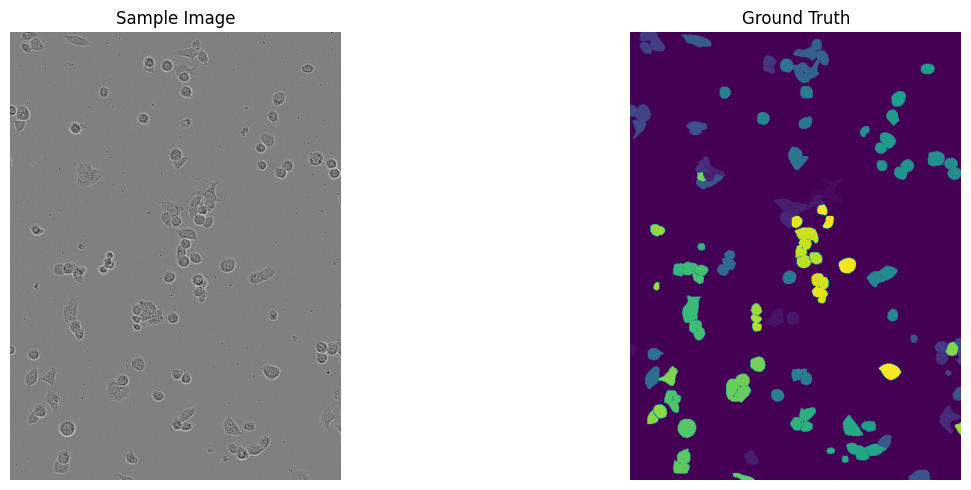

In [8]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt

livecell_dir = os.path.join(root_dir, "data", "live_cell")
if not os.path.exists(livecell_dir):
    os.mkdir(livecell_dir)


def load_lc_items(jpath, n, phase):

    items=[]
    coco = COCO(jpath)
    for x in tqdm(range(n)):
        img_id = coco.getImgIds()[x]  # Get the first image ID
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        mask = coco.annToMask(anns[0])  # Get mask for the first annotation
        mask = np.zeros((coco.imgs[img_id]['height'], coco.imgs[img_id]['width']),int)
        
        for i,ann in enumerate(anns):
            arr2 = coco.annToMask(ann) * i
            mask = np.where(arr2 != 0, arr2, mask)
            
        mask_path=os.path.join(livecell_dir, "{}/mask_{}.npz".format(phase,x))
        if not os.path.exists(mask_path):
            np.savez_compressed(mask_path,mask.T)
            
        img_info = coco.loadImgs(img_id)[0]
        
        if phase=="test":
            lc_root = os.path.join(livecell_dir, "images/livecell_test_images")
        else:
            lc_root = os.path.join(livecell_dir, "images/livecell_train_val_images")
            
        fname = os.path.basename(img_info['file_name'])
        fpath = os.path.join(lc_root,fname)
        
        items = add_item(fpath, mask_path, items, "livecell")

    return items

its = load_lc_items(os.path.join(livecell_dir, "livecell_coco_train.json"),500,"train")
Segmentation_Dataset['Train'] = its
Segmentation_Dataset['Validation'] = load_lc_items(os.path.join(livecell_dir, "livecell_coco_val.json"),100,"val")
Segmentation_Dataset['Test'] = load_lc_items(os.path.join(livecell_dir, "livecell_coco_test.json"),20,"test")

print("{} items added".format(120))
show_data(its)

## Define a transform to load and preprocess the image and visualize the inference results


{'image': '/datasets/monai_workshop/data/live_cell/images/livecell_test_images/BT474_Phase_D3_1_01d16h00m_2.tif', 'label': '/datasets/monai_workshop/data/live_cell/test/mask_14.npz', 'fold': 0}


(3, 704, 520)
(704, 520)
(704, 520)
(704, 520, 3)


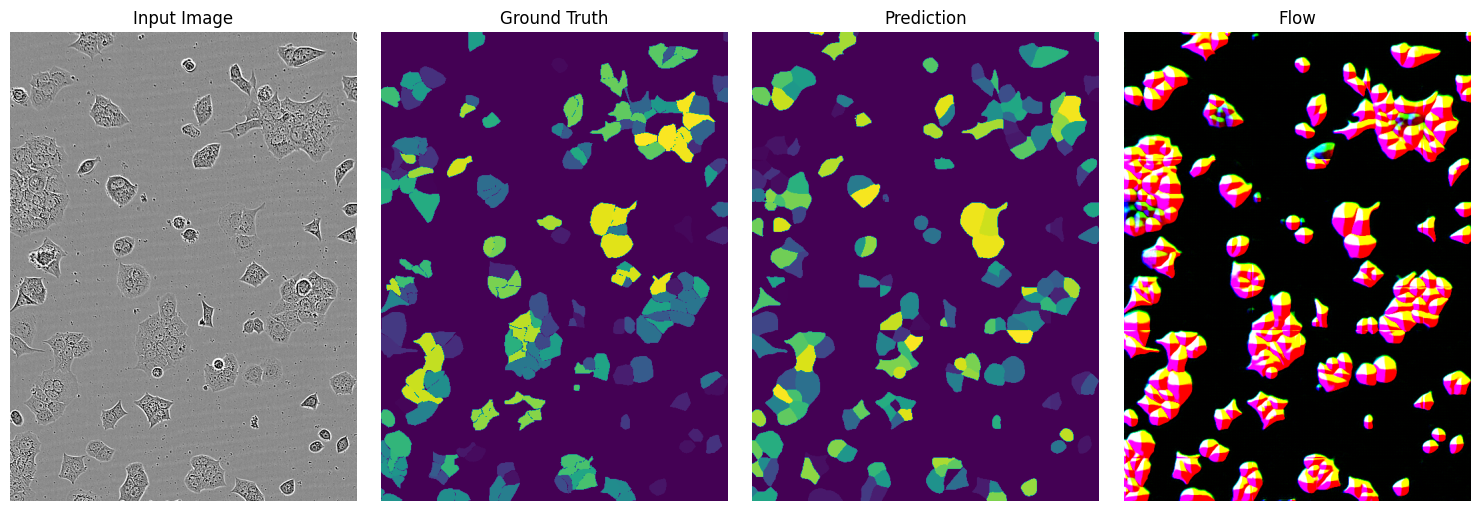

Image shape: (704, 520, 3)
Label shape: (704, 520)
Prediction shape: (704, 520)
Unique values in label: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176

In [9]:
warnings.filterwarnings('ignore')

from monai.utils.type_conversion import convert_data_type, convert_to_dst_type, convert_to_tensor

amp_dtype = torch.float16
optimizer = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

# Define Sliding Window Inferer for validation
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256], sw_batch_size=1, overlap=0.25, cache_roi_weight_map=True, progress=False
)

class Sort2DChannelsd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        if "image" in self.keys:
            if len(data["image"].shape)==2:
                data["image"] = data["image"].unsqueeze(0)
                
            if len(data["image"].shape)==3:
                if data["image"].shape[2]==1:
                    data["image"] = data["image"].repeat(1, 1, 3) 
                    data["image"] = data["image"].to(memory_format=torch.contiguous_format)
                elif data["image"].shape[0]==1:
                    data["image"] = data["image"].repeat(3, 1, 1) 


        if "label" in self.keys:
            if len(data["label"].shape)==3:
                if data["label"].shape[2]==1:
                    data["label"] = data["label"].to(memory_format=torch.contiguous_format)
            if len(data["label"].shape)==2:
                data["label"] = data["label"].unsqueeze(0)
                

        return data


def test_random_image(test_list):
    
    preprocess_im = Compose([LoadImaged(keys=["image", "label"],image_only=False), Sort2DChannelsd(keys=["image", "label"]), ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),])

    n_samples = len(test_list)
    random_number = random.randint(0, n_samples-1)

    # Load a single validation image (index 2)
    val_item = test_list[random_number]
    print(val_item)
    
    # Load and preprocess the image and label
    items = preprocess_im(val_item)
    image = items["image"]
    label = items["label"]
    
    # Ensure model is in eval mode and on the correct device
    model.eval()
    model.to(device)
    
    # Perform inference
    with torch.no_grad():
        input_tensor = torch.as_tensor(image).unsqueeze(0).to(device)
        with autocast(dtype=amp_dtype):
            logits = sliding_inferrer(inputs=input_tensor, network=model)
    
    # Convert logits to prediction mask
    pred_mask = LogitsToLabels()(logits=logits[0])
    
    # Move tensors to CPU and convert to numpy for visualization
    image = image.squeeze().cpu().numpy()
    label = label.squeeze().cpu().numpy()

    # shuffle the instance values
    unique_values = np.unique(pred_mask[pred_mask > 0])
    np.random.shuffle(unique_values)

    # Replace original values with shuffled ones
    shuffled_mask = np.zeros_like(pred_mask)
    for old_val, new_val in zip(np.unique(pred_mask[pred_mask > 0]), unique_values):
        shuffled_mask[pred_mask == old_val] = new_val
    
    print(image.shape)
    print(label.shape)
    print(shuffled_mask.shape)
    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    # Handle potential multi-channel images
    if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
        image = np.transpose(image, (1, 2, 0))
        if image.shape[2] == 1:
            image = image[:, :, 0]

    print(image.shape)
    
    axes[0].imshow(image, cmap="gray" if image.ndim == 2 else None)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    if label.ndim == 3 and label.shape[0] == 1:
        label = label[0]
    axes[1].imshow(label, cmap="viridis")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    if shuffled_mask.ndim == 3 and shuffled_mask.shape[0] == 1:
        shuffled_mask = shuffled_mask[0]
    axes[2].imshow(shuffled_mask, cmap="viridis")
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    flow = np.squeeze(logits.cpu().numpy())
    if flow.ndim == 3 and flow.shape[0] < 5:
        flow = np.transpose(flow, (1, 2, 0))
    axes[3].imshow(flow)
    axes[3].set_title("Flow")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Prediction shape: {pred_mask.shape}")
    print(f"Unique values in label: {np.unique(label)}")
    print(f"Unique values in prediction: {np.unique(pred_mask)}")

#test_random_image(testing_list)
test_random_image(Segmentation_Dataset["Test"])

## More Training Data
For fine-tuning or retraining there are other datasets you could include (collapsed)

**TNBC**

In [ ]:
tnbc_dir = os.path.join(root_dir, "data", "TNBC_NucleiSegmentation")
zip_file_path = os.path.join(zip_file_dir , "TNBC_NucleiSegmentation.zip")

if not os.path.exists(tnbc_dir):
    extract(zip_file_path, tnbc_dir)

file_path = os.path.join(tnbc_dir , "TNBC_and_Brain_dataset")
folders = os.listdir(file_path)

items=[]

for i,folder in enumerate(tqdm(folders)):
    if "Slide_" in str(folder):
        for file in sorted(os.listdir(os.path.join(file_path,folder))):
            file = os.path.join(file_path,folder,file)
            if ".DS_Store" not in str(file):
                image = str(file)
                im_data = io.imread(image)
                if im_data.shape[2]>3:
                    im_data = im_data[:,:,:3]
                    io.imsave(str(file),im_data)     
                masks = str(file).replace("Slide_","GT_")
                if os.path.exists(masks):
                    mask_data = io.imread(masks)
                    # print(np.unique(mask_data))
                    mask_data = separate_touching_objects(mask_data)
                    mask_data, remapping = fastremap.renumber(mask_data, in_place=True)
                    mask_data = fastremap.refit(mask_data)
                    os.remove(masks)
                    masks = masks.replace(".png",".npy")
                    np.save(masks,mask_data.T)
                else:
                    masks = masks.replace(".png",".npy")
                    
                items = add_item(image, masks, items, "TNBC_2018")

np.random.seed(42) 
np.random.shuffle(items)
print("{} items loaded".format(len(items)))
Segmentation_Dataset['Train']+=items[:int(len(items)*0.8)]
Segmentation_Dataset['Validation']+=items[int(len(items)*0.8):int(len(items)*0.9)]
Segmentation_Dataset['Test']+=items[int(len(items)*0.9):]

show_data(items)

**LyNSec**

In [ ]:
lynsec_dir= os.path.join(root_dir, "data", "LyNSeC")
zip_file_path = os.path.join(zip_file_dir , "LyNSeC.zip")

if not os.path.exists(lynsec_dir):
    extract(zip_file_path, lynsec_dir)
    
file_path = lynsec_dir
folders = os.listdir(file_path)

items = []

for i, folder in enumerate(tqdm(folders)):
    if folder[:8] == "lynsec 2":  # Skip incorrectly annotated folder
        #print("skip")
        continue


    for j, file in enumerate(sorted(os.listdir(os.path.join(file_path,folder)))):
        file_ =os.path.join(file_path,folder,file)
        if ".DS_Store" not in str(file_) and ".png" not in str(file):
            mask_file = str(file_)
            image_file = mask_file.replace(".npy",".png")
            if not os.path.exists(image_file):
                data = np.load(str(file_))
                np.save(mask_file, data[:, :, 3].T)
                io.imsave(image_file,data[:, :, :3].astype(np.uint8))
            items = add_item(image_file, mask_file, items, "LyNSeC")

np.random.seed(42) 
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]
Segmentation_Dataset['Test'] += items[int(len(items) * 0.9):]

print("{} items loaded".format(len(items)))

show_data(items)

**IHC TMA**

In [ ]:
ihc_tma_dir = os.path.join(root_dir, "data", "IHC_TMA_dataset")
zip_file_path = os.path.join(zip_file_dir , "IHC_TMA_dataset.zip")

if not os.path.exists(ihc_tma_dir):
    extract(zip_file_path, ihc_tma_dir)
    
file_path = ihc_tma_dir + "/IHC_TMA_dataset/images"
files = sorted(os.listdir(file_path))

items = []

for i, file in enumerate(tqdm(files)):
    image =os.path.join(file_path,file)
    
    mask_path = str(os.path.join(file_path,file)).replace("images", "masks").replace(".png", ".npy")
    masks = np.load(mask_path)
    if masks.shape!=(256,256):
        n_masks = np.max(masks[0:2], axis=0)
    
        masks = separate_touching_objects(n_masks)
        masks, remapping = fastremap.renumber(masks, in_place=True)
        masks = fastremap.refit(masks)
        
        np.save(mask_path,masks.T)
        
    items = add_item(image, mask_path, items, "IHC_TMA","IHC")

np.random.seed(42)
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]
Segmentation_Dataset['Test'] += items[int(len(items) * 0.9):]

show_data(items)


**MoNuSeg**

In [ ]:
monuseg_dir= os.path.join(root_dir, "data", "MoNuSeg")
zip_file_path = os.path.join(zip_file_dir , "MoNuSeg.zip")

if not os.path.exists(monuseg_dir):
    extract(zip_file_path, monuseg_dir)
    
file_path = os.path.join(monuseg_dir,"monuseg-2018/download")

# Process Test Data
items = []
set_type = "test"
test_files = os.listdir(os.path.join(file_path,set_type,"images"))

for file in tqdm(test_files):
    if ".DS_Store" not in str(file):
        image = os.path.join(file_path,set_type,"images",file)
        masks = str(image).replace("images", "masks")
        if ".tif" in image:
            im = io.imread(image)
            os.remove(image)
            image = image.replace(".tif",".png")
            io.imsave(image,im[:,:,:3])
            mk = io.imread(masks)
            os.remove(masks)
            masks = masks.replace(".tif",".npz")
            np.savez_compressed(masks,mk.T)
        else:
            masks = masks.replace(".png",".npz")
        
        items = add_item(image, masks, items, "MoNuSeg")
        
Segmentation_Dataset['Test'] += items[:int(len(items) * 0.5)]
Segmentation_Dataset['Validation'] += items[:int(len(items) * 0.5)]

# Process Train Data
items = []
set_type = "train"
train_files = os.listdir(os.path.join(file_path,set_type,"images"))

for file in tqdm(train_files):
    if ".DS_Store" not in str(file):
        image = os.path.join(file_path,set_type,"images",file)
        masks = str(image).replace("images", "masks")
        if ".tif" in image:
            im = io.imread(image)
            os.remove(image)
            image = image.replace(".tif",".png")
            io.imsave(image,im[:,:,:3])
            mk = io.imread(masks)
            os.remove(masks)
            masks = masks.replace(".tif",".npz")
            np.savez_compressed(masks,mk.T)
        else:
            masks = masks.replace(".png",".npz")
        
        items = add_item(image, masks, items, "MoNuSeg")

np.random.seed(42)
np.random.shuffle(items)
print("{} items added".format(len(items)))
Segmentation_Dataset['Train'] += items[:int(len(items) * 0.8)]
Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]

show_data(items)

**PANNUKE**

In [ ]:
pannuke_dir = os.path.join(root_dir, "data", "PanNuke")
if not os.path.exists(pannuke_dir):
    os.mkdir(pannuke_dir)

for fold in ["1", "2"]:
    if not os.path.exists(os.path.join(pannuke_dir, "Fold {}".format(fold))):
        if not os.path.exists(os.path.join(pannuke_dir, "PanNuke_fold_{}.zip".format(fold))):
            zip_file_path = os.path.join(zip_file_dir, "PanNuke_fold_{}.zip".format(fold))
    
            # Download and unzip the dataset
            extract(zip_file_path, pannuke_dir)


In [ ]:
warnings.filterwarnings('ignore')

def get_data(dataset):

    if dataset == "train":
        fold = "1"
    elif dataset == "val":
        fold = "2"

    create_files=False
    out_path = os.path.join(pannuke_dir,"all_images")
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        create_files=True
    out_path = os.path.join(out_path,dataset)
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        create_files=True

    items = []
    masks = np.load(os.path.join(pannuke_dir,"Fold {}/masks/fold{}/masks.npy".format(fold,fold)), allow_pickle = True).astype(np.int16)
    images = np.load(os.path.join(pannuke_dir,"Fold {}/images/fold{}/images.npy".format(fold,fold)), allow_pickle = True).astype(np.uint8)

    for i in tqdm(range(len(images))):

        assert (np.unique(masks[i,:,:,:-1]) == np.unique(masks[i,:,:,:-1].max(-1))).all()
        label = masks[i,:,:,:-1].max(-1)
        label,_ = fastremap.renumber(label, in_place=True)
        classes = (np.argmax(masks[i,:,:,:-1],axis = -1) + 1) * (label > 0).astype(np.int8)

        image = images[i]
        relative_path_img = os.path.join(out_path , "image_"+str(i)+".png")
        relative_path_nucleus =os.path.join(out_path , "nucleus_masks_"+str(i)+".npz")
        if create_files:
            io.imsave(relative_path_img,image)
            np.savez_compressed(relative_path_nucleus, label.T)

        items = add_item(relative_path_img, relative_path_nucleus, items, "PanNuke")
        if fold==1:
            print("{} items added".format(len(items)))

    return items
    
items = get_data("train")
Segmentation_Dataset['Train']+=items
items = get_data("val")
Segmentation_Dataset['Validation']+=items[:int(len(items) * 0.5)]
Segmentation_Dataset['Test']+=items[int(len(items) * 0.5):]

show_data(items)

## Begin Training/Fine Tuning

In [11]:
warnings.filterwarnings(action="default")
warnings.filterwarnings(action="ignore")

roi_size = [256, 256]
train_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=False),
        mt.RepeatChanneld(keys=["image"],repeats=3),
        mt.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 0.0)),
        mt.EnsureTyped(keys=["image", "label"], data_type="tensor", dtype=torch.float),
        mt.ScaleIntensityd(keys="image", minv=0, maxv=1, channel_wise=True),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.SpatialPadd(keys=["image", "label"], spatial_size=roi_size),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        mt.RandAffined(
            keys=["image", "label"],
            prob=0.5,
            rotate_range=np.pi,
            scale_range=[-0.5, 0.5],
            mode=["bilinear", "nearest"],
            spatial_size=roi_size,
            cache_grid=True,
            padding_mode="border",
        ),
        mt.RandAxisFlipd(keys=["image", "label"], prob=0.5),
        mt.RandGaussianNoised(keys=["image"], prob=0.25, mean=0, std=0.1),
        mt.RandAdjustContrastd(keys=["image"], prob=0.25, gamma=(1, 2)),
        mt.RandGaussianSmoothd(keys=["image"], prob=0.25, sigma_x=(1, 2)),
        mt.RandHistogramShiftd(keys=["image"], prob=0.25, num_control_points=3),
        mt.RandGaussianSharpend(keys=["image"], prob=0.25),
        LabelsToFlows(keys="label", flow_key="flow"),
    ]
)

val_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=False),
        mt.RepeatChanneld(keys=["image"],repeats=3),
        mt.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 0.0)),
        mt.EnsureTyped(
            keys=["image", "label"],
            data_type="tensor",
            dtype=torch.float,
            allow_missing_keys=True,
        ),
        mt.ScaleIntensityRangePercentilesd(
            keys="image",
            lower=1,
            upper=99,
            b_min=0.0,
            b_max=1.0,
            channel_wise=True,
            clip=True,
        ),
        mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        LabelsToFlows(keys="label", flow_key="flow", allow_missing_keys=True),
    ]
)

# Datasets & Dataloaders for training, validation and testing
train_dataset = Dataset(data=Segmentation_Dataset['Train'], transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True, shuffle=True, num_workers=1)

val_dataset = Dataset(data=Segmentation_Dataset['Validation'], transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1)

# Training loop with validation
loss_function = CellLoss()
acc_function = CellAcc()

# Define the Sliding Window Inferer
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256], sw_batch_size=1, overlap=0.25, cache_roi_weight_map=True, progress=False
)

channels_last = True
   
ckpt_path = os.path.join(root_dir, "model_checkpoints")
if os.path.exists(ckpt_path) is False:
    os.mkdir(ckpt_path)
    
max_epochs = 5
num_epochs_per_validation = 1

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

# Amp
scaler = GradScaler()
amp_dtype = torch.float16

best_ckpt_path = os.path.join(ckpt_path, "model.pt")
intermediate_ckpt_path = os.path.join(ckpt_path, "model_final.pt")

best_metric = -1
start_epoch = 0
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss_values = []
val_epoch_acc_values = []
for epoch in range(0, max_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0

    model.train()
    memory_format = torch.channels_last if channels_last else torch.preserve_format
    run_loss = CumulativeAverage()
    avg_loss = avg_acc = 0

    for idx, batch_data in enumerate(train_loader):
        data = batch_data["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)
        target = batch_data["flow"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast with float16 for mixed precision training
        with autocast(dtype=amp_dtype):
            logits = model(data)
            loss = loss_function(logits.float(), target)

        # Use the scaler for backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = data.shape[0]
        run_loss.append(loss, count=batch_size)
        avg_loss = run_loss.aggregate()

        if idx % 10==0:
            print(f"Epoch {epoch}/{max_epochs} {idx}/{len(train_loader)} ")
            print(f"loss: {avg_loss:.4f} time {time.time() - start_time:.2f}s ")

    optimizer.zero_grad()

    epoch_loss_values.append(avg_loss)

    # Validation loop & model checkpoints
    if epoch % num_epochs_per_validation == 0:
        optimizer.zero_grad(set_to_none=True)
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            val_run_loss = CumulativeAverage()
            run_acc = CumulativeAverage()
            for val_idx, val_batch in enumerate(val_loader):
                v_data = val_batch["image"].as_subclass(torch.Tensor).to(memory_format=memory_format, device=device)

                target = val_batch["flow"].as_subclass(torch.Tensor).to(device=device)

                filename = val_batch["image"].meta[ImageMetaKey.FILENAME_OR_OBJ]
                batch_size = v_data.shape[0]
                loss = acc = None
                # Use autocast with float16 for mixed precision validation
                with autocast(dtype=amp_dtype):
                    logits = sliding_inferrer(inputs=v_data, network=model)
                    val_loss = loss_function(logits, target)

                val_run_loss.append(val_loss.to(device=device), count=batch_size)
                target = None

                pred_mask_all = []

                for b_ind in range(logits.shape[0]):  # go over batch dim
                    pred_mask = LogitsToLabels()(logits=logits[b_ind], filename=filename)
                    pred_mask_all.append(pred_mask)

                if acc_function is not None:
                    label = val_batch["label"].as_subclass(torch.Tensor)

                    for b_ind in range(label.shape[0]):
                        acc = acc_function(pred_mask_all[b_ind], label[b_ind, 0].long())
                        acc = acc.detach().clone() if isinstance(acc, torch.Tensor) else torch.tensor(acc)

                        run_acc.append(acc.to(device=device), count=1)
                    label = None

                avg_loss = val_loss.cpu() if val_loss is not None else 0
                avg_acc = acc.cpu().numpy() if acc is not None else 0

            print(f"Val loss: {val_run_loss.aggregate():.4f} acc {run_acc.aggregate()}  time {time.time() - start_time:.2f}s")

        val_epoch_loss_values.append(val_run_loss.aggregate())
        val_epoch_acc_values.append(run_acc.aggregate())
        
    # Model Saving & Checkpointing
    if avg_loss < best_metric:
        best_metric = avg_loss
        state_dict = model.state_dict()
        torch.save({"state_dict": state_dict}, best_ckpt_path)
        print(f"Model saved to {best_ckpt_path}")
        
print("Training Complete!")

Epoch 0/5 0/62 
loss: 0.9096 time 2.77s 


Epoch 0/5 10/62 
loss: 0.9324 time 18.43s 


Epoch 0/5 20/62 
loss: 0.9156 time 33.97s 
Epoch 0/5 30/62 
loss: 0.9164 time 49.54s 
Epoch 0/5 40/62 
loss: 0.9205 time 65.13s 
Epoch 0/5 50/62 
loss: 0.9004 time 80.21s 
Epoch 0/5 60/62 
loss: 0.8842 time 95.37s 
Val loss: 0.9856 acc 0.14358709752559662  time 124.53s
Epoch 1/5 0/62 
loss: 0.8094 time 2.28s 
Epoch 1/5 10/62 
loss: 0.7884 time 16.98s 
Epoch 1/5 20/62 
loss: 0.7910 time 31.35s 
Epoch 1/5 30/62 
loss: 0.8425 time 46.89s 


Epoch 1/5 40/62 
loss: 0.8712 time 61.90s 
Epoch 1/5 50/62 
loss: 0.8894 time 76.95s 
Epoch 1/5 60/62 
loss: 0.8796 time 91.31s 
Val loss: 1.0152 acc 0.14759905636310577  time 120.22s
Epoch 2/5 0/62 
loss: 0.6954 time 2.27s 
Epoch 2/5 10/62 
loss: 0.7751 time 16.57s 
Epoch 2/5 20/62 
loss: 0.8499 time 31.74s 


Epoch 2/5 30/62 
loss: 0.8482 time 46.31s 
Epoch 2/5 40/62 
loss: 0.8633 time 61.52s 
Epoch 2/5 50/62 
loss: 0.8683 time 76.52s 


Epoch 2/5 60/62 
loss: 0.8814 time 91.46s 
Val loss: 1.0647 acc 0.1457359939813614  time 120.59s
Epoch 3/5 0/62 
loss: 1.0288 time 2.63s 


Epoch 3/5 10/62 
loss: 0.9498 time 18.09s 
Epoch 3/5 20/62 
loss: 0.8822 time 32.74s 


Epoch 3/5 30/62 
loss: 0.8857 time 47.49s 
Epoch 3/5 40/62 
loss: 0.8552 time 61.53s 
Epoch 3/5 50/62 
loss: 0.8625 time 76.37s 
Epoch 3/5 60/62 
loss: 0.8592 time 90.56s 
Val loss: 0.9692 acc 0.14027905464172363  time 119.61s
Epoch 4/5 0/62 
loss: 0.9722 time 2.45s 


Epoch 4/5 10/62 
loss: 0.8520 time 17.01s 
Epoch 4/5 20/62 
loss: 0.8463 time 31.86s 
Epoch 4/5 30/62 
loss: 0.8793 time 46.88s 
Epoch 4/5 40/62 
loss: 0.8724 time 61.27s 
Epoch 4/5 50/62 
loss: 0.8791 time 76.09s 


Epoch 4/5 60/62 
loss: 0.8836 time 91.04s 
Val loss: 0.9774 acc 0.14908674359321594  time 119.79s
Training Complete!


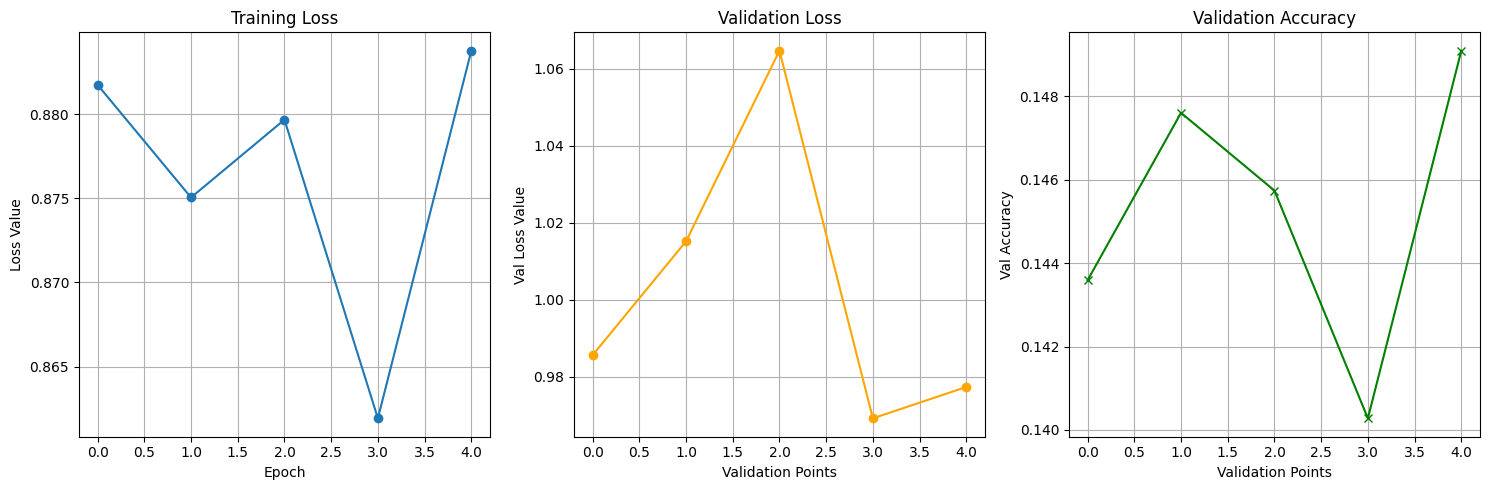

In [12]:
def show_metrics():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Loss
    axs[0].plot(range(0, max_epochs), epoch_loss_values, marker="o")
    axs[0].set_title("Training Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss Value")
    axs[0].grid(True)
    
    # Plot 2: Validation Loss
    axs[1].plot(val_epoch_loss_values, marker="o", color="orange")
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Validation Points")
    axs[1].set_ylabel("Val Loss Value")
    axs[1].grid(True)
    
    # Plot 3: Validation Accuracy
    axs[2].plot(val_epoch_acc_values, marker="x", color="green")
    axs[2].set_title("Validation Accuracy")
    axs[2].set_xlabel("Validation Points")
    axs[2].set_ylabel("Val Accuracy")
    axs[2].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

show_metrics()

{'image': '/datasets/monai_workshop/data/live_cell/images/livecell_test_images/BT474_Phase_D3_2_00d00h00m_1.tif', 'label': '/datasets/monai_workshop/data/live_cell/test/mask_18.npz', 'fold': 0}


(3, 704, 520)
(704, 520)
(704, 520)
(704, 520, 3)


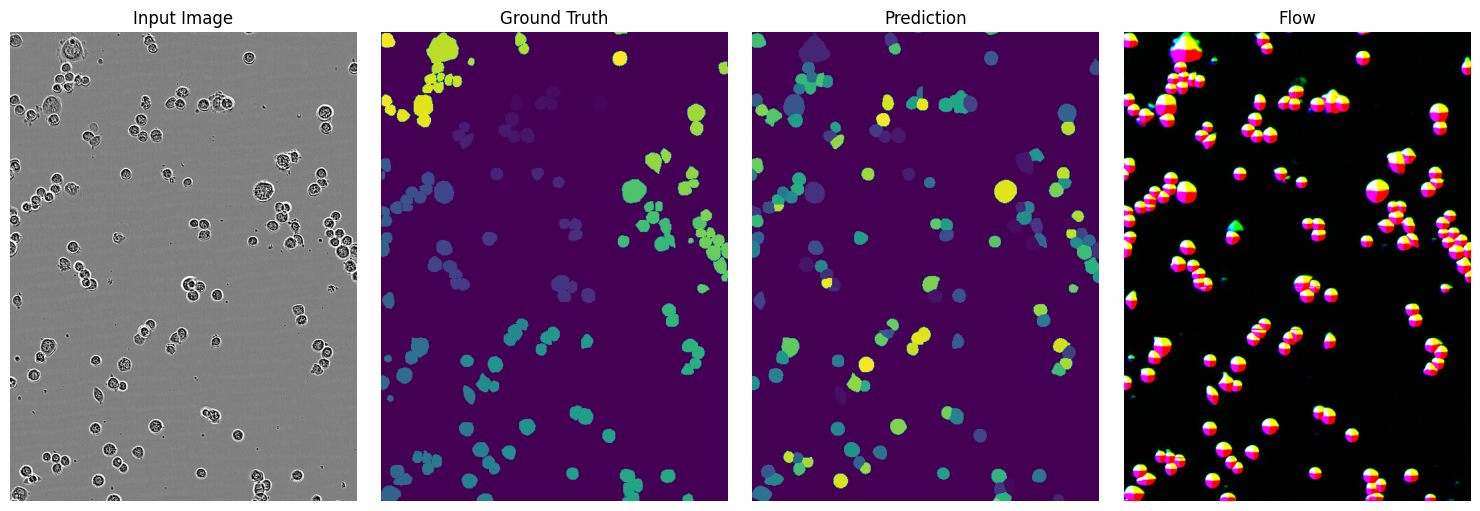

Image shape: (704, 520, 3)
Label shape: (704, 520)
Prediction shape: (704, 520)
Unique values in label: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142.]
Unique values in prediction: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  3

In [13]:
test_random_image(Segmentation_Dataset['Test'])